In [1]:
import math

import matplotlib.pyplot as plt
import stanza
from stanza.models.common.doc import Word, Sentence

In [2]:
stanza_analyzer = stanza.Pipeline(
    lang="ru",
    processors="tokenize,pos,lemma",
    download_method=stanza.DownloadMethod.REUSE_RESOURCES
)

2024-03-24 21:29:29 INFO: Loading these models for language: ru (Russian):
| Processor | Package            |
----------------------------------
| tokenize  | syntagrus          |
| pos       | syntagrus_charlm   |
| lemma     | syntagrus_nocharlm |

2024-03-24 21:29:29 INFO: Using device: cpu
2024-03-24 21:29:29 INFO: Loading: tokenize
2024-03-24 21:29:30 INFO: Loading: pos
2024-03-24 21:29:31 INFO: Loading: lemma
2024-03-24 21:29:31 INFO: Done loading processors!


In [3]:
# чтение файлов
full_text = ""
for i in range(1, 6):
    with open(f"articles/{i}.txt", "r", encoding="utf-8") as file:
        full_text += file.read()

# сегментация на предложения, токенизация,
# определение части речи и морфлогических характеристик, лемматизация
doc = stanza_analyzer(full_text)

In [4]:
n = doc.num_words
print(f"Общее количество слов во всех текстах: {n}")

Общее количество слов во всех текстах: 17711


In [5]:
# подсчёт частоты встречаемости в тексте всех лемм, являющихся существительными и прилагательными
lemmas = {}
n = 0
for sentence in doc.sentences:
    for word in sentence.words:
        n += 1
        if word.pos in ["NOUN", "ADJ"]:
            lemmas[word.lemma] = lemmas.get(word.lemma, 0) + 1

In [6]:
COLLOCATION_PATTERNS = [
    ("ADJ", "NOUN"),
    ("NOUN", "NOUN"),
]
UNIVERSAL_TO_OPENCORPORA_FEATURES_MAPPING = {
    "Masc": "masc",
    "Fem": "femn",
    "Neut": "neut",
}

collocations = {}
filtered_out_collocations = []


# проверяет, согласуются ли слова
def check_words_agreement(words: tuple[Word], sentence: Sentence, pattern: tuple[str]):
    words_features = []
    for word in words:
        if not word.feats:
            word.feats = "="
        words_features.append(dict(map(lambda x: x.split("="), word.feats.split("|"))))

    # отсеивание слов, которые не согласуются по признакам, присутствующим у обоих слов
    # (только для синтаксического типа A N)
    if pattern == COLLOCATION_PATTERNS[0]:
        features = set(words_features[0].keys()).intersection(words_features[1].keys())
        for feature in features:
            if words_features[0].get(feature) != words_features[1].get(feature):
                filtered_out_collocations.append(
                    {
                        "words": (words[0].text, words[1].text),
                        "features": words[0].feats + ";" + words[1].feats,
                        "sentence": sentence.text
                    }
                )
                return

    # добавление в список "потенциальных" коллокаций
    collocation = words[0].lemma + " " + words[1].lemma
    if collocation not in collocations:
        collocations[collocation] = {
            "pattern": pattern,
            "frequency": 0,
            "variations": set()
        }
    collocations[collocation]["frequency"] += 1
    collocations[collocation]["variations"].add(
        (words[0].text + " " + words[1].text).lower()
    )


# итерация по всем парам подряд идущих слов в предложении
for sentence in doc.sentences:
    for word_i in range(0, len(sentence.words) - 1):
        words = sentence.words[word_i], sentence.words[word_i + 1]
        for pattern in COLLOCATION_PATTERNS:
            if words[0].pos == pattern[0] and words[1].pos == pattern[1]:
                check_words_agreement(words, sentence, pattern)


In [7]:
filtered_out_count = len(filtered_out_collocations)
possible_count = len(collocations)
possible_A_N_count = len(
    list(
        filter(
            lambda x: x[1]["pattern"] == ('ADJ', 'NOUN'),
            collocations.items()
        )
    )
)
possible_N_N_count = possible_count - possible_A_N_count

print(
    f"Отсеянные словосочетания: {filtered_out_count}\n"
    f"Потенциальные коллокации: {possible_count}\n"
    f"                     A N: {possible_A_N_count}\n"
    f"                     N N: {possible_N_N_count}"
)

Отсеянные словосочетания: 29
Потенциальные коллокации: 1784
                     A N: 1233
                     N N: 551


In [8]:
# отсеянные словосочетания
filtered_out_collocations

[{'words': ('государственных', 'языка'),
  'features': 'Case=Gen|Degree=Pos|Number=Plur;Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing',
  'sentence': 'Опыт языкового строительства в Беларуси демонстрирует уникальную для пост-советских стран ситуацию, когда два государственных языка, белорусский и русский, используются в условиях диглоссии.'},
 {'words': ('русского', 'языков'),
  'features': 'Case=Gen|Degree=Pos|Gender=Masc|Number=Sing;Animacy=Inan|Case=Gen|Gender=Masc|Number=Plur',
  'sentence': 'Внешняя стабильность языковой ситуации в современной Беларуси, отсутствие конфликтов на языковой почве, достаточно благополучное сосуществование и функционирование белорусского и русского языков, связанны не только с советским, но и с более отдаленным историческим прошлым страны.'},
 {'words': ('языковой', 'политика'),
  'features': 'Case=Gen|Degree=Pos|Gender=Fem|Number=Sing;Animacy=Inan|Case=Nom|Gender=Fem|Number=Sing',
  'sentence': 'Реальная языковая ситуация является результатом языковой 

In [9]:
# подсчёт значений мер ассоциации
for collocation, info in collocations.items():
    words = collocation.split(" ")

    f_ab = info["frequency"]
    f_a = lemmas[words[0]]
    f_b = lemmas[words[1]]

    info["MI"] = math.log2(f_ab * n / f_a / f_b)
    info["MI3"] = math.log2(f_ab ** 3 * n / f_a / f_b)
    info["t_score"] = (f_ab - f_a * f_b / n) / math.sqrt(f_ab)
    info["dice"] = 2 * f_ab / (f_a + f_b)

In [10]:
# разделение словосочетаний по двум грамматическим образцам
collocations_A_N = dict(
    filter(
        lambda x: x[1]["pattern"] == ('ADJ', 'NOUN'),
        collocations.items()
    )
)
collocations_N_N = dict(
    filter(
        lambda x: x[1]["pattern"] == ('NOUN', 'NOUN'),
        collocations.items()
    )
)

In [11]:
def filter_collocations(collocations: dict, filter: str) -> list:
    return list(
        sorted(
            collocations.items(),
            key=lambda x: x[1][filter],
            reverse=True
        )
    )

### A N (прилагательное-существительное)

In [12]:
# по частоте встречаемости в тексте
filter_collocations(collocations_A_N, "frequency")[:20]

[('белорусский язык',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 51,
   'variations': {'белорусский язык',
    'белорусским языком',
    'белорусского языка',
    'белорусском языке',
    'белорусскому языку'},
   'MI': 4.062509502059485,
   'MI3': 15.407360186002476,
   't_score': 6.714015287881373,
   'dice': 0.21748400852878466}),
 ('русский язык',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 24,
   'variations': {'русский язык',
    'русским языком',
    'русского языка',
    'русском языке',
    'русскому языку'},
   'MI': 4.6325777874809475,
   'MI3': 13.80250278892326,
   't_score': 4.7014823734499105,
   'dice': 0.16666666666666666}),
 ('xx век',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 20,
   'variations': {'xx в.',
    'xx вв.',
    'xx века',
    'хх в',
    'хх в.',
    'хх вв',
    'хх века'},
   'MI': 8.942433050067734,
   'MI3': 17.586289239842458,
   't_score': 4.463045734550142,
   'dice': 0.7407407407407407}),
 ('языковой политика',
  {'pattern': ('ADJ', '

In [13]:
# по мере MI
filter_collocations(collocations_A_N, "MI")[:20]

[('благополучный сосуществование',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 1,
   'variations': {'благополучное сосуществование'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('межрегиональный столкновение',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 1,
   'variations': {'межрегиональных столкновений'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('деловой бумага',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 1,
   'variations': {'деловых бумаг'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('постоянный носитель',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 1,
   'variations': {'постоянных носителей'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('одноязычный анклав',
  {'pattern': ('ADJ', 'NOUN'),
   'f

In [14]:
# по мере MI3
filter_collocations(collocations_A_N, "MI3")[:20]

[('xx век',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 20,
   'variations': {'xx в.',
    'xx вв.',
    'xx века',
    'хх в',
    'хх в.',
    'хх вв',
    'хх века'},
   'MI': 8.942433050067734,
   'MI3': 17.586289239842458,
   't_score': 4.463045734550142,
   'dice': 0.7407407407407407}),
 ('исторический наука',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 14,
   'variations': {'историческая наука',
    'исторических наук',
    'исторической науке',
    'исторической науки'},
   'MI': 8.334750472846494,
   'MI3': 15.949460316961703,
   't_score': 3.730068169124529,
   'dice': 0.5}),
 ('педагогический техникум',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 4,
   'variations': {'педагогические техникумы', 'педагогический техникум'},
   'MI': 11.790429956622685,
   'MI3': 15.790429956622685,
   't_score': 1.9994353791429056,
   'dice': 0.8888888888888888}),
 ('простой мова',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 3,
   'variations': {'проста мова', 'простая мова'},
   '

In [15]:
# по мере t_score
filter_collocations(collocations_A_N, "t_score")[:20]

[('белорусский язык',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 51,
   'variations': {'белорусский язык',
    'белорусским языком',
    'белорусского языка',
    'белорусском языке',
    'белорусскому языку'},
   'MI': 4.062509502059485,
   'MI3': 15.407360186002476,
   't_score': 6.714015287881373,
   'dice': 0.21748400852878466}),
 ('русский язык',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 24,
   'variations': {'русский язык',
    'русским языком',
    'русского языка',
    'русском языке',
    'русскому языку'},
   'MI': 4.6325777874809475,
   'MI3': 13.80250278892326,
   't_score': 4.7014823734499105,
   'dice': 0.16666666666666666}),
 ('xx век',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 20,
   'variations': {'xx в.',
    'xx вв.',
    'xx века',
    'хх в',
    'хх в.',
    'хх вв',
    'хх века'},
   'MI': 8.942433050067734,
   'MI3': 17.586289239842458,
   't_score': 4.463045734550142,
   'dice': 0.7407407407407407}),
 ('языковой политика',
  {'pattern': ('ADJ', '

In [16]:
# по мере Dice
filter_collocations(collocations_A_N, "dice")[:20]

[('благополучный сосуществование',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 1,
   'variations': {'благополучное сосуществование'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('межрегиональный столкновение',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 1,
   'variations': {'межрегиональных столкновений'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('деловой бумага',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 1,
   'variations': {'деловых бумаг'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('простой мова',
  {'pattern': ('ADJ', 'NOUN'),
   'frequency': 3,
   'variations': {'проста мова', 'простая мова'},
   'MI': 12.52739555078889,
   'MI3': 15.697320552231202,
   't_score': 1.7317574219654273,
   'dice': 1.0}),
 ('постоянный носитель',
  {'pattern': ('ADJ', 'NOUN'),
   'f

### N N (существительное-существительное)

In [17]:
# по частоте встречаемости в тексте
filter_collocations(collocations_N_N, "frequency")[:20]

[('политика белорусизация',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 15,
   'variations': {'политика белорусизации',
    'политике белорусизации',
    'политики белорусизации',
    'политикой белорусизации'},
   'MI': 5.6694145556613185,
   'MI3': 13.483195746878355,
   't_score': 3.796883848467019,
   'dice': 0.20408163265306123}),
 ('сфера образование',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 4,
   'variations': {'сфере образования',
    'сферу образования',
    'сферы образования'},
   'MI': 6.980501090901254,
   'MI3': 10.980501090901253,
   't_score': 1.9841623849585004,
   'dice': 0.16}),
 ('процесс белорусизация',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 4,
   'variations': {'процесса белорусизации',
    'процессах белорусизации',
    'процессов белорусизации',
    'процессы белорусизации'},
   'MI': 5.0355424544592156,
   'MI3': 9.035542454459216,
   't_score': 1.9390209474337983,
   'dice': 0.08333333333333333}),
 ('миллион человек',
  {'pattern': ('NOUN'

In [18]:
# по мере MI
filter_collocations(collocations_N_N, "MI")[:20]

[('ликвидация неграмотность',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 1,
   'variations': {'ликвидацию неграмотности'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('вуз столица',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 1,
   'variations': {'вузах столицы'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('толща иноземщина',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 1,
   'variations': {'толщу иноземщины'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('уничтожение собака',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 1,
   'variations': {'уничтожение собак'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('тушение пожар',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 1,
   'variations': {'тушение 

In [19]:
# по мере MI3
filter_collocations(collocations_N_N, "MI3")[:20]

[('форпост западнорусизм',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 2,
   'variations': {'форпосты западнорусизма'},
   'MI': 13.112358051510046,
   'MI3': 15.112358051510046,
   't_score': 1.4140538634783546,
   'dice': 1.0}),
 ('черта оседлость',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 2,
   'variations': {'черта оседлости', 'черты оседлости'},
   'MI': 12.52739555078889,
   'MI3': 14.52739555078889,
   't_score': 1.4139740140309844,
   'dice': 0.8}),
 ('очаг денационализация',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 2,
   'variations': {'очаги денационализации'},
   'MI': 12.52739555078889,
   'MI3': 14.52739555078889,
   't_score': 1.4139740140309844,
   'dice': 0.8}),
 ('ликвидация неграмотность',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 1,
   'variations': {'ликвидацию неграмотности'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('вуз столица',
  {'pattern': ('NOUN', 'NOUN'),
   'fre

In [20]:
# по мере t_score
filter_collocations(collocations_N_N, "t_score")[:20]

[('политика белорусизация',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 15,
   'variations': {'политика белорусизации',
    'политике белорусизации',
    'политики белорусизации',
    'политикой белорусизации'},
   'MI': 5.6694145556613185,
   'MI3': 13.483195746878355,
   't_score': 3.796883848467019,
   'dice': 0.20408163265306123}),
 ('сфера образование',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 4,
   'variations': {'сфере образования',
    'сферу образования',
    'сферы образования'},
   'MI': 6.980501090901254,
   'MI3': 10.980501090901253,
   't_score': 1.9841623849585004,
   'dice': 0.16}),
 ('процесс белорусизация',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 4,
   'variations': {'процесса белорусизации',
    'процессах белорусизации',
    'процессов белорусизации',
    'процессы белорусизации'},
   'MI': 5.0355424544592156,
   'MI3': 9.035542454459216,
   't_score': 1.9390209474337983,
   'dice': 0.08333333333333333}),
 ('динамика трансформация',
  {'pattern': 

In [21]:
# по мере Dice
filter_collocations(collocations_N_N, "dice")[:20]

[('ликвидация неграмотность',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 1,
   'variations': {'ликвидацию неграмотности'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('форпост западнорусизм',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 2,
   'variations': {'форпосты западнорусизма'},
   'MI': 13.112358051510046,
   'MI3': 15.112358051510046,
   't_score': 1.4140538634783546,
   'dice': 1.0}),
 ('вуз столица',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 1,
   'variations': {'вузах столицы'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('толща иноземщина',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 1,
   'variations': {'толщу иноземщины'},
   'MI': 14.112358051510046,
   'MI3': 14.112358051510046,
   't_score': 0.9999435379142906,
   'dice': 1.0}),
 ('уничтожение собака',
  {'pattern': ('NOUN', 'NOUN'),
   'frequency': 1,
   'variation

### Графики

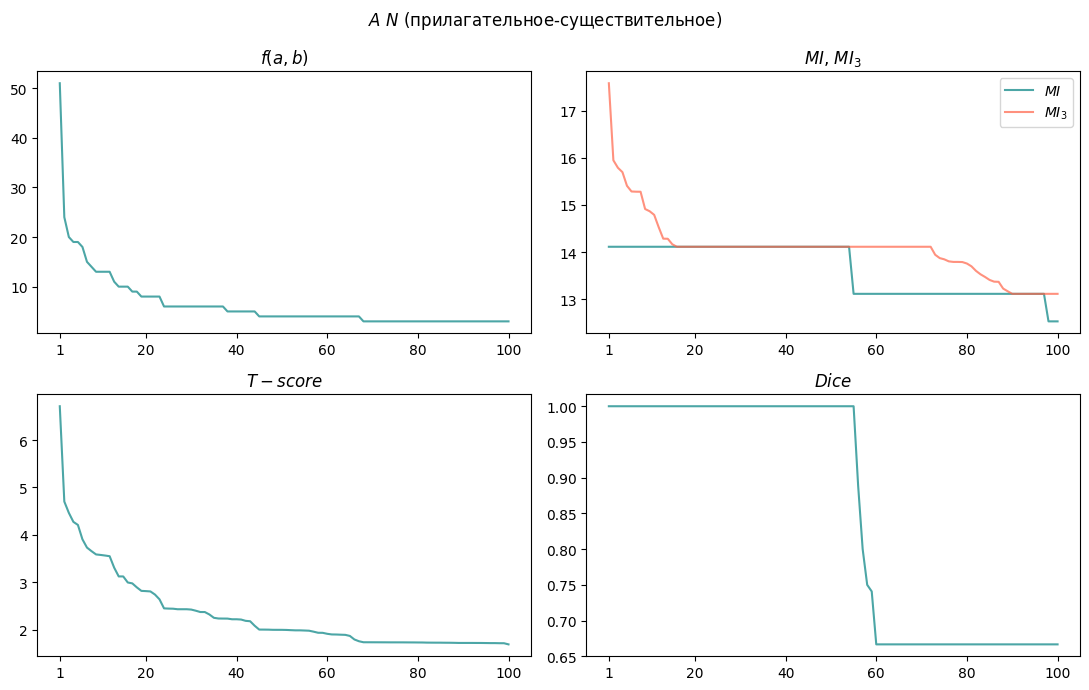

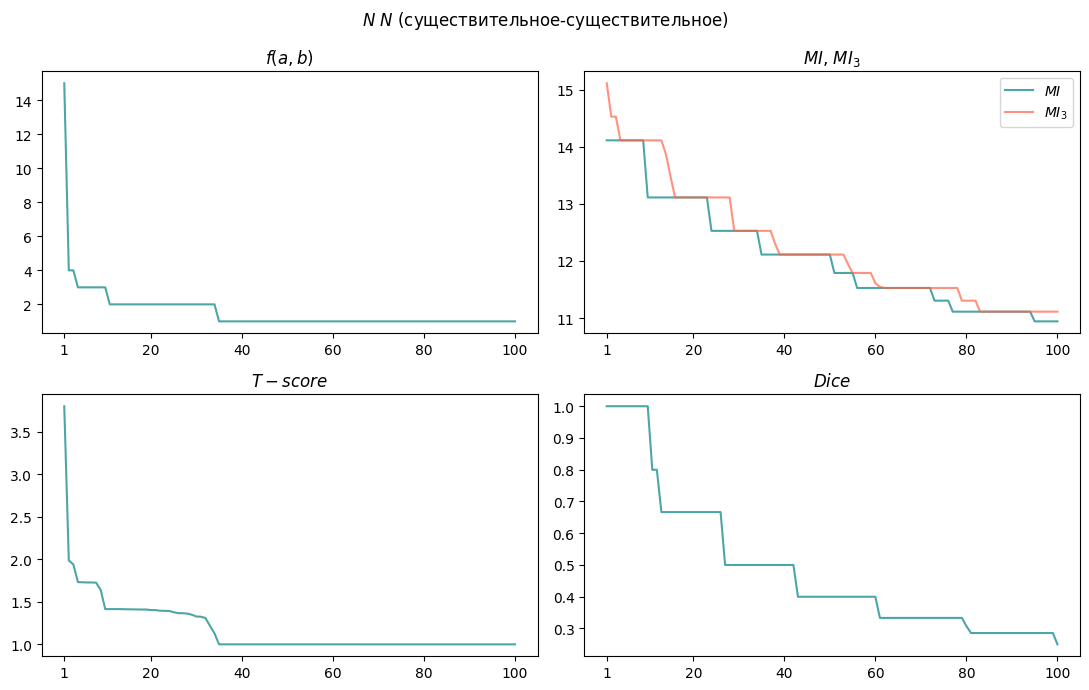

In [22]:
collocations_with_names = [
    (collocations_A_N, "$A$ $N$ (прилагательное-существительное)", "A_N"),
    (collocations_N_N, "$N$ $N$ (существительное-существительное)", "N_N")
]
x = list(range(1, 101))

for collocations, plotname, filename in collocations_with_names:
    fig, axs = plt.subplots(2, 2, figsize=(11, 7))
    y_freq = list(
        map(lambda x: x[1]["frequency"], filter_collocations(collocations, "frequency")[:100])
    )
    y_mi = list(
        map(lambda x: x[1]["MI"], filter_collocations(collocations, "MI")[:100])
    )
    y_mi3 = list(
        map(lambda x: x[1]["MI3"], filter_collocations(collocations, "MI3")[:100])
    )
    y_tscore = list(
        map(lambda x: x[1]["t_score"], filter_collocations(collocations, "t_score")[:100])
    )
    y_dice = list(
        map(lambda x: x[1]["dice"], filter_collocations(collocations, "dice")[:100])
    )
    
    axs[0][0].plot(x, y_freq, alpha=0.7, c="teal")
    axs[0][0].set_title("$f(a, b)$")
    
    axs[0][1].plot(x, y_mi, label="$MI$", alpha=0.7, c="teal")
    axs[0][1].plot(x, y_mi3, label="$MI_3$", alpha=0.7, c="tomato")
    axs[0][1].set_title("$MI$, $MI_3$")
    axs[0][1].legend()
    
    axs[1][0].plot(x, y_tscore, alpha=0.7, c="teal")
    axs[1][0].set_title("$T-score$")
    
    axs[1][1].plot(x, y_dice, alpha=0.7, c="teal")
    axs[1][1].set_title("$Dice$")

    plt.setp(axs, xticks=[1, 20, 40, 60, 80, 100])
    fig.suptitle(plotname)
    fig.tight_layout()
    # fig.savefig(filename + ".png")
    plt.show()